<a href="https://colab.research.google.com/github/ShagMichail/Industrial-Analytics-Platforms/blob/main/Task/Task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задание 3

Подключаем необходимые библиотеки

In [ ]:
!pip install --upgrade gensim
import os
os.kill(os.getpid(), 9)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 15.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions
from gensim.models import Word2Vec

### Задание 1
Сформировать обучающую выборку из загруженного датасета, состоящую из столбцов: ['Count_subj', 'rr_interval', 'p_end',  'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status’]. Датасет состоит из числовых параметров ЭКГ и классификационного признака Healthy_Status.

In [2]:
dataset = pd.read_csv('dataset.csv')
dataset.head(10)

,subject_id,Count_subj,study_id,cart_id,Healthy_Status,eeg_time,eeg_date,report_0,report_1,report_2,...,filtering,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis
0,19557662,27,40000017,6848296,0,8:44 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,659,40,128,170,258,518,81,77,79
1,18477137,93,40000029,6848296,0,9:54 AM,27.06.2015,Sinus rhythm,Possible right atrial abnormality,NaN,...,60 Hz notch Baseline filter,722,40,124,162,246,504,77,75,70
2,16598616,3,40000035,6376932,1,9:07 AM,28.06.2015,Sinus tachycardia,NaN,Normal ECG except for rate,...,60 Hz notch Baseline filter,600,40,130,162,244,474,79,72,77
3,16368287,7,40000079,6214760,1,5:14 PM,15.07.2015,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,659,40,146,180,254,538,79,66,69
4,18370366,2,40000084,6632385,0,1:52 PM,27.09.2015,Sinus rhythm,NaN,NaN,...,<not specified>,659,368,29999,504,590,868,84,80,77
5,15606157,55,40000089,6632385,0,2:29 PM,29.10.2013,Sinus rhythm,NaN,NaN,...,<not specified>,822,365,29999,499,592,852,26,46,30
6,12576058,43,40000115,6852956,1,12:54 PM,23.03.2016,Sinus rhythm,NaN,Normal ECG,...,60 Hz notch Baseline filter,952,40,146,198,282,598,24,80,20
7,14691089,1,40000143,6551957,0,10:01 AM,10.12.2016,Sinus rhythm,rSr'(V1) - probable normal variant,Low QRS voltages in precordial leads,...,60 Hz notch Baseline filter,923,40,140,188,278,594,26,86,13
8,14144725,7,40000144,6924910,0,7:24 AM,11.12.2011,Sinus rhythm with PAC(s).,NaN,Borderline ECG,...,60 Hz notch Baseline filter,952,40,180,196,294,610,59,-17,3
9,16089780,2,40000152,6919786,0,12:35 PM,13.12.2011,Sinus rhythm,Extensive T wave changes may be due to myocard...,NaN,...,60 Hz notch Baseline filter,1000,40,156,178,274,584,8,-11,19


In [4]:
# Предобрабатываем данные словестных репортов word2vec в числовой вектор

# Убираем выбросы
columns_to_filter = ['rr_interval', 'p_onset', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis']
full_df_filtered = dataset[(dataset[columns_to_filter] < 2000).all(axis=1)]
full_df_filtered = full_df_filtered[(full_df_filtered['p_onset'] < full_df_filtered['p_end']) & (full_df_filtered['qrs_onset'] < full_df_filtered['qrs_end'])]

# Слепляем все текстовые отчеты в один большой
reports = [f'report_{x}' for x in range(18)]
full_df_filtered['report_0'] = full_df_filtered[reports].astype(str).agg(' '.join, axis=1)
full_df_filtered['report_0'] = full_df_filtered['report_0'].str.replace(r'\bnan\b', '', regex=True).str.replace(r'\s+', ' ', regex=True).str.strip()
full_df_filtered.rename(columns={'report_0': 'report'}, inplace=True)
reports_to_drop = [f'report_{x}' for x in range(1, 18)]
full_df_filtered = full_df_filtered.drop(reports_to_drop, axis=1)

# Фиксим имена столбцов
full_df_filtered = full_df_filtered.rename(columns={'eeg_time ': 'eeg_time', 'eeg_date ': 'eeg_date'})
full_df_filtered = full_df_filtered.drop(columns = ['bandwidth', 'filtering'])

# Делаем колонку с таргетами крайней справа
full_df_filtered = full_df_filtered[[col for col in full_df_filtered.columns if col != 'Healthy_Status'] + ['Healthy_Status']]

# Разбиваем столбец с текстовым отчетом на токены
words = [text.split() for text in full_df_filtered['report']]

# Обучаем модель Word2Vec
w2v_model = Word2Vec(words)

# Функция для получения среднего эмбеддинга строки
def get_sentence_embedding(sentence):
    words = sentence.split()
    word_vectors = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    if word_vectors:
        return np.mean(word_vectors, axis=0)  # Усреднённый вектор
    else:
        return np.zeros(w2v_model.vector_size)  # Нулевой вектор, если слова нет в модели

# Применяем функцию ко всей колонке и переводим каждый вектор в одно число
full_df_filtered['report'] = full_df_filtered['report'].apply(lambda x: get_sentence_embedding(x).mean())

full_df_filtered.head()

,subject_id,Count_subj,study_id,cart_id,eeg_time,eeg_date,report,rr_interval,p_onset,p_end,qrs_onset,qrs_end,t_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,19557662,27,40000017,6848296,8:44 AM,27.06.2015,0.032462,659,40,128,170,258,518,81,77,79,0
1,18477137,93,40000029,6848296,9:54 AM,27.06.2015,0.032462,722,40,124,162,246,504,77,75,70,0
2,16598616,3,40000035,6376932,9:07 AM,28.06.2015,-0.007634,600,40,130,162,244,474,79,72,77,1
3,16368287,7,40000079,6214760,5:14 PM,15.07.2015,0.004997,659,40,146,180,254,538,79,66,69,1
6,12576058,43,40000115,6852956,12:54 PM,23.03.2016,0.004997,952,40,146,198,282,598,24,80,20,1


In [5]:
# make new dataset from old columns
table_data = full_df_filtered[['Count_subj', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()
table_data.head()

,Count_subj,rr_interval,p_end,qrs_onset,qrs_end,p_axis,qrs_axis,t_axis,Healthy_Status
0,27,659,128,170,258,81,77,79,0
1,93,722,124,162,246,77,75,70,0
2,3,600,130,162,244,79,72,77,1
3,7,659,146,180,254,79,66,69,1
6,43,952,146,198,282,24,80,20,1


### Задание 2
Используя выбранные ранее решения AutoML, найдите наиболее эффективное, используя такие метрика качества как: матрица ошибок (confusion matrix) и F1-метрика для оценки обученного классификатора по признаку Healthy_Status на основе данных параметров ЭКГ.

##AutoML H2O

In [6]:
!pip install h2o

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.9/265.9 MB 3.4 MB/s eta 0:00:00


In [7]:
import h2o
from h2o.frame import H2OFrame
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score

In [8]:
# Инициализируем H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.26" 2025-01-21; OpenJDK Runtime Environment (build 11.0.26+4-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.26+4-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.11/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvcxebc4m
  JVM stdout: /tmp/tmpvcxebc4m/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpvcxebc4m/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,5 days
H2O_cluster_name:,H2O_from_python_unknownUser_w2q649
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [10]:
# Переводим датафрейм в формат H2OFrame
h2o_df = H2OFrame(table_data)

# Разбиение на обучающую и тестовую выборки
random_seed = 17
train, test = h2o_df.split_frame(ratios=[0.85], seed=random_seed)

# Определяем целевую переменную и предикторы
y="Healthy_Status"
x = list(h2o_df.columns)
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [11]:
# Создаем и обучаем модель H2O AutoML
automl = H2OAutoML(max_runtime_secs=60, seed=random_seed, verbosity="info")
#automl= H2OAutoML(max_models = 10, seed = 10, exclude_algos = ["StackedEnsemble", "DeepLearning"], verbosity="info", nfolds=0)


automl.train(x=x, y=y, training_frame=train)

# Оценка модели на тестовом наборе
performance = automl.leader.model_performance(test_data=test)
print(performance)

AutoML progress: |
12:12:17.420: Project: AutoML_1_20250402_121217
12:12:17.423: 5-fold cross-validation will be used.
12:12:17.423: Setting stopping tolerance adaptively based on the training frame: 0.012934759914813772
12:12:17.424: Build control seed: 17
12:12:17.424: training frame: Frame key: AutoML_1_20250402_121217_training_py_2_sid_a514    cols: 9    rows: 5977  chunks: 1    size: 91017  checksum: 38620050880055
12:12:17.425: validation frame: NULL
12:12:17.425: leaderboard frame: NULL
12:12:17.432: blending frame: NULL
12:12:17.433: response column: Healthy_Status
12:12:17.433: fold column: null
12:12:17.433: weights column: null
12:12:17.474: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w), def_3 (3g, 10w), grid_1 (4g, 90w), lr_search (6g, 30w)]}, {GLM : [def_1 (1g, 10w)]}, {DRF : [def_1 (2g, 10w), XRT (3g, 10w)]}, {GBM : [def_5 (1g, 10w), def_2 (2g, 10w), def_3 (2g, 10w), def_4 (2g, 10w), def_1 (3g, 10w), grid_1 (4g, 60w), lr_annealing (6g, 10w)]}, {De

In [12]:
lb = automl.leaderboard
lb.head()

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_2_AutoML_1_20250402_121217,0.361801,0.1309,0.273618,0.254466,0.1309
StackedEnsemble_AllModels_1_AutoML_1_20250402_121217,0.361918,0.130984,0.272095,0.25425,0.130984
StackedEnsemble_BestOfFamily_3_AutoML_1_20250402_121217,0.362522,0.131422,0.274248,0.254886,0.131422
StackedEnsemble_BestOfFamily_2_AutoML_1_20250402_121217,0.362917,0.131709,0.272946,0.254888,0.131709
GBM_3_AutoML_1_20250402_121217,0.363765,0.132325,0.277021,0.25521,0.132325
GBM_2_AutoML_1_20250402_121217,0.364225,0.13266,0.27957,0.255833,0.13266
GBM_4_AutoML_1_20250402_121217,0.364756,0.133047,0.275629,0.255817,0.133047
GBM_1_AutoML_1_20250402_121217,0.366223,0.13412,0.282809,0.2573,0.13412
StackedEnsemble_BestOfFamily_1_AutoML_1_20250402_121217,0.366442,0.134279,0.281645,0.257624,0.134279
XGBoost_3_AutoML_1_20250402_121217,0.367796,0.135274,0.288672,0.259441,0.135274


In [13]:
model_ids = list(automl.leaderboard['model_id'].as_data_frame().iloc[:,0])
model_ids

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


['StackedEnsemble_AllModels_2_AutoML_1_20250402_121217',
 'StackedEnsemble_AllModels_1_AutoML_1_20250402_121217',
 'StackedEnsemble_BestOfFamily_3_AutoML_1_20250402_121217',
 'StackedEnsemble_BestOfFamily_2_AutoML_1_20250402_121217',
 'GBM_3_AutoML_1_20250402_121217',
 'GBM_2_AutoML_1_20250402_121217',
 'GBM_4_AutoML_1_20250402_121217',
 'GBM_1_AutoML_1_20250402_121217',
 'StackedEnsemble_BestOfFamily_1_AutoML_1_20250402_121217',
 'XGBoost_3_AutoML_1_20250402_121217',
 'GBM_5_AutoML_1_20250402_121217',
 'DRF_1_AutoML_1_20250402_121217',
 'XRT_1_AutoML_1_20250402_121217',
 'DeepLearning_1_AutoML_1_20250402_121217',
 'XGBoost_2_AutoML_1_20250402_121217',
 'XGBoost_1_AutoML_1_20250402_121217',
 'GLM_1_AutoML_1_20250402_121217']

In [14]:
out = h2o.get_model([mid for mid in model_ids if "XGBoost" in mid][0])
out.convert_H2OXGBoostParams_2_XGBoostParams()

({'silent': True,
  'eta': 0.3,
  'colsample_bylevel': 0.8,
  'objective': 'reg:squarederror',
  'min_child_weight': 3.0,
  'nthread': 2,
  'seed': 28,
  'max_depth': 5,
  'colsample_bytree': 0.8,
  'lambda': 1.0,
  'gamma': 0.0,
  'alpha': 0.0,
  'booster': 'gbtree',
  'grow_policy': 'depthwise',
  'nround': 14,
  'subsample': 0.8,
  'max_delta_step': 0.0,
  'tree_method': 'exact'},
 14)

In [15]:
automl.leader.model_performance(test)

ModelMetricsRegressionGLM: stackedensemble
** Reported on test data. **

MSE: 0.13228752957547785
RMSE: 0.3637135267975029
MAE: 0.2773781737717194
RMSLE: 0.255698869920982
Mean Residual Deviance: 0.13228752957547785
R^2: 0.3611363423381737
Null degrees of freedom: 1068
Residual degrees of freedom: 1060
Null deviance: 221.44853674628007
Residual deviance: 141.41536911618581
AIC: 891.3414675004897

In [16]:
test_predict = automl.predict(test)

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


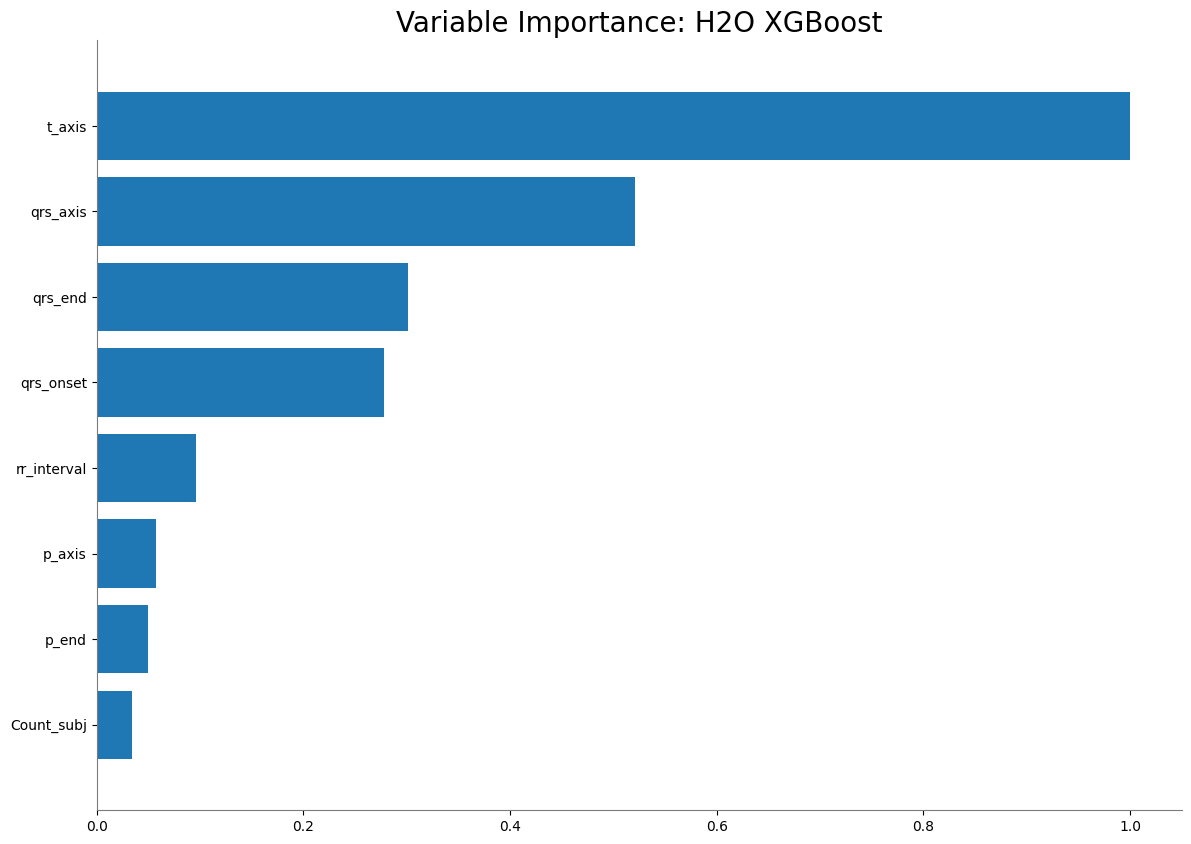

<Figure size 640x480 with 0 Axes>

In [17]:
out.varimp_plot()

In [18]:
# H2OFrame
test_preds = h2o.as_list(test_predict)
test_preds = test_preds['predict']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [19]:
test_Y = h2o.as_list(test['Healthy_Status'])
test_Y = test_Y['Healthy_Status']

/usr/local/lib/python3.11/dist-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [20]:
# Вычисляем F1-меру с помощью confusion matrix

# Порог отсечения - 0.5
for i in range(len(test_preds)):
  if test_preds[i] > 0.5:
    test_preds[i] = 1
  else:
    test_preds[i] = 0


cm = confusion_matrix(test_Y, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(test_Y, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

Confusion matrix: [[624 132]
 [ 89 224]]
F1-Score:  0.67
Accuracy: 0.79
Recall:  0.72
Precision:  0.63


In [21]:
# Завершение работы H2O
h2o.shutdown()

H2O session _sid_a514 closed.


<ipython-input-21-9ae954ad13ba>:2: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


##AutoML BlueCast

In [22]:
!pip install bluecast --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.0/182.0 kB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.4/194.4 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 86.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "

In [41]:
import numpy as np
import pandas as pd
import re


from bluecast.blueprints.cast import BlueCast
from bluecast.blueprints.cast_cv import BlueCastCV
from bluecast.config.training_config import TrainingConfig, XgboostTuneParamsConfig
from bluecast.preprocessing.custom import CustomPreprocessing
from bluecast.general_utils.general_utils import save_to_production, load_for_production

from sklearn.model_selection import StratifiedKFold, RepeatedKFold

In [42]:
# Убираем из датасета лишние столбцы
autoML_df = full_df_filtered[['report', 'rr_interval', 'p_end', 'qrs_onset', 'qrs_end', 't_end', 'p_axis', 'qrs_axis', 't_axis', 'Healthy_Status']].copy()

autoML_df = autoML_df.drop(columns='report')

# Разбиение на обучающую и тестовую выборки

random_seed = 13

# set the classification index of table
clf_index = autoML_df.shape[1]-1

auto_X = autoML_df.iloc[:, :clf_index]
auto_Y = autoML_df.iloc[:, [clf_index]]
auto_X_train, auto_X_test, auto_Y_train, auto_Y_test = train_test_split(auto_X, auto_Y, train_size=0.85, random_state=random_seed, stratify=auto_Y)

# Склеиваем признаки и таргеты в один датафрейм (только для обучающей выборки)
auto_train_df = auto_X_train
auto_train_df['Healthy_Status'] = auto_Y_train

In [43]:
seed = 13

target = 'Healthy_Status'

# Создание обучающего набора с помощью выборки pandas — видимый набор данных
train_dataset = autoML_df.sample(frac=.8, random_state=seed)
#knowledge.reset_index(inplace=True, drop=True)
print('выделяем из исходного набора данныз базу для обучения: ', train_dataset.shape)

# Использование образцов, недоступных в обучающем наборе, в качестве будущего или невидимого набора данных
test_dataset = autoML_df.drop(train_dataset.index)
#payload.reset_index(inplace=True, drop=True)
print('набор данных для проверки: ',test_dataset.shape)

выделяем из исходного набора данныз базу для обучения:  (5637, 9)
набор данных для проверки:  (1409, 9)


In [44]:
from bluecast.preprocessing.feature_types import FeatureTypeDetector

feat_type_detector = FeatureTypeDetector()
train_data = feat_type_detector.fit_transform_feature_types(train_dataset)

len(feat_type_detector.num_columns)

9

In [45]:
#Automatic feature type detection from BlueCast
print(feat_type_detector.date_columns)

[]


In [46]:
feat_type_detector.num_columns

['rr_interval',
 'p_end',
 'qrs_onset',
 'qrs_end',
 't_end',
 'p_axis',
 'qrs_axis',
 't_axis',
 'Healthy_Status']

In [47]:
feat_type_detector.cat_columns

[]

In [48]:
automl = BlueCast(class_problem="binary")

automl.conf_training.hyperparameter_tuning_rounds = 10
automl.conf_training.calculate_shap_values = False
automl.conf_training.use_full_data_for_final_model = False

2025-04-02 12:26:21,503 - root - INFO - BlueCast blueprint initialized.


2025-04-02 12:26:33,446 - root - INFO - Start detecting and casting feature types.
2025-04-02 12:26:33,450 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-04-02 12:26:33,453 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-04-02 12:26:33,463 - root - INFO - Dropped the following columns as constants only: [].
2025-04-02 12:26:33,465 - root - INFO - Dropped the following columns as constants only: [].
2025-04-02 12:26:33,587 - root - WARNING - /usr/local/lib/python3.11/dist-packages/bluecast/blueprints/cast.py:295: UserWarning: Feature selection is disabled. Update the TrainingConfig param 'enable_feature_selection'
            to enable it or make use of a custom preprocessor to do it manually during the last mile computations step.
            Feature selection is recommended for datasets with many features (>1000). For datasets with a small amount
            of features feature selection is not recommended.
            
2025-04-

  0%|          | 0/10 [00:00<?, ?it/s]

2025-04-02 12:32:18,923 - root - INFO - New best score: 0.3690165650429508 from random seed  33
2025-04-02 12:32:18,926 - root - INFO - Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
2025-04-02 12:32:18,929 - root - INFO - Start final model training


Best params: {'validate_parameters': False, 'objective': 'multi:softprob', 'booster': 'gbtree', 'eval_metric': 'mlogloss', 'num_class': 2, 'max_depth': 3, 'alpha': 1.5311302050301745e-05, 'lambda': 2.0889560100230935, 'gamma': 0.22114169335491826, 'min_child_weight': 7.460608390823226, 'subsample': 1.0, 'colsample_bytree': 0.8433310708488493, 'colsample_bylevel': 0.8776067335500239, 'eta': 0.18299142989294398, 'steps': 1000, 'tree_method': 'approx', 'grow_policy': 'lossguide', 'max_bin': 585}
Finished hyperparameter tuning


2025-04-02 12:32:19,718 - root - INFO - Finished training
2025-04-02 12:32:19,722 - root - INFO - Start casting feature types.
2025-04-02 12:32:19,723 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-04-02 12:32:19,724 - root - INFO - Dropped the following columns as constants only: [].
2025-04-02 12:32:19,725 - root - INFO - Start filling infinite values.
2025-04-02 12:32:19,726 - root - INFO - Start date column conversion (transform).
2025-04-02 12:32:19,727 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-04-02 12:32:19,729 - root - INFO - Start transforming categories with binary target encoder.
2025-04-02 12:32:19,731 - root - INFO - Start transforming categories with binary target encoder.
2025-04-02 12:32:19,736 - root - INFO - Predicting...
2025-04-02 12:32:19,737 - root - INFO - Start predicting on new data using Xgboost model.
2025-04-02 12:32:19,786 - root - INFO - Finished predicting
2025-04-02 

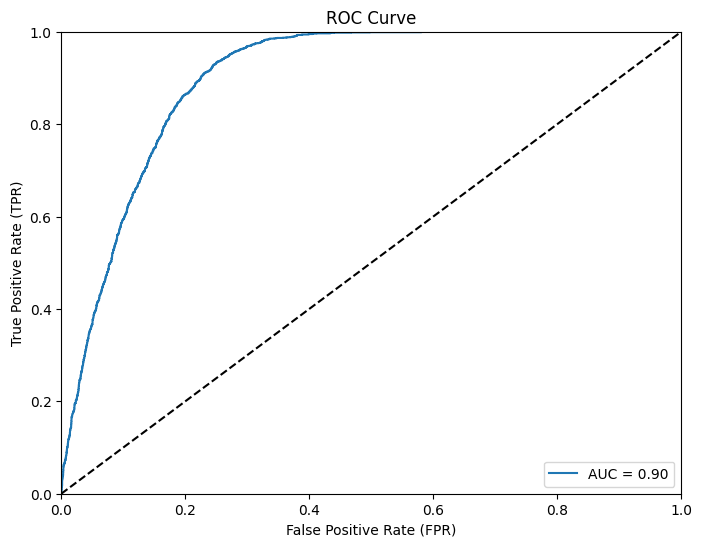

2025-04-02 12:32:20,063 - root - WARNING - /usr/local/lib/python3.11/dist-packages/bluecast/evaluation/eval_metrics.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


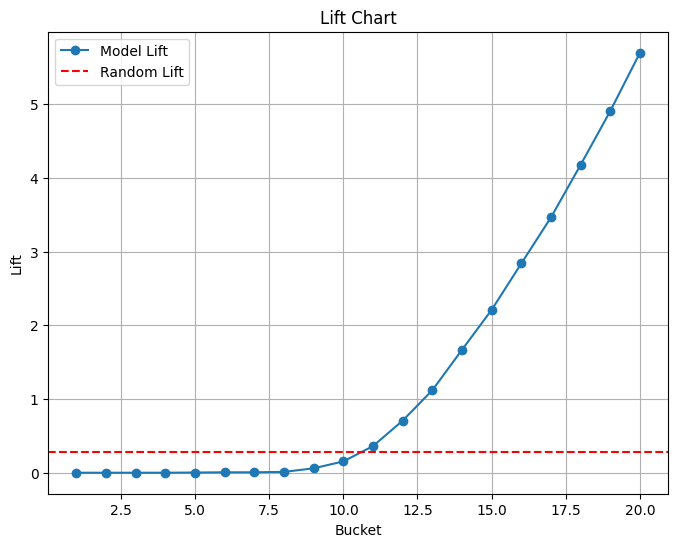

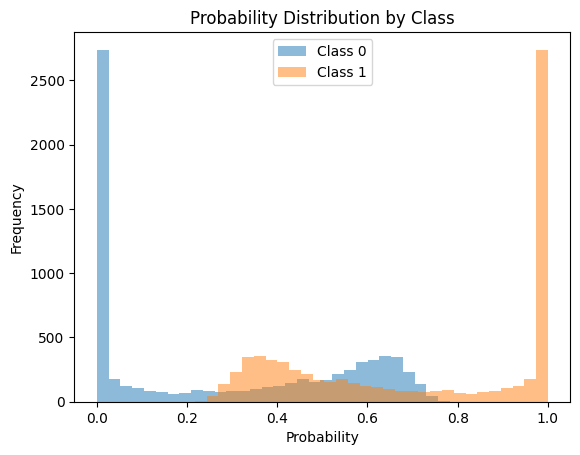

2025-04-02 12:32:20,555 - root - INFO - Start saving out of fold data.


{'matthews': 0.5861512017032863,
 'accuracy': 0.8207493613397673,
 'recall': 0.8207493613397673,
 'f1_score_macro': 0.7904569854653062,
 'f1_score_micro': 0.8207493613397673,
 'f1_score_weighted': 0.8247408539428597,
 'log_loss': 0.34513433270237215,
 'balanced_logloss': 0.4222891926765442,
 'roc_auc': 0.8994821458888729,
 'classfication_report': '              precision    recall  f1-score   support\n\n           0       0.90      0.84      0.87      5039\n           1       0.66      0.77      0.71      2007\n\n    accuracy                           0.82      7046\n   macro avg       0.78      0.81      0.79      7046\nweighted avg       0.83      0.82      0.82      7046\n',
 'confusion_matrix': array([[4231,  808],
        [ 455, 1552]])}

In [49]:
automl.fit_eval(
    df=autoML_df,
    df_eval=autoML_df.drop('Healthy_Status', axis=1),
    target_eval=autoML_df['Healthy_Status'],
    target_col="Healthy_Status",
)

In [50]:
y_probs, test_preds = automl.predict(auto_X_test)

# Вычисляем F1-меру с помощью confusion matrix
cm = confusion_matrix(auto_Y_test, test_preds)
TN, FP, FN, TP = cm.ravel()
precision = TP / (TP + FP) if (TP + FP) != 0 else 0
recall = TP / (TP + FN) if (TP + FN) != 0 else 0
Accuracy = (TP + TN) / (TP + TN + FN + FP)
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

roc_auc = roc_auc_score(auto_Y_test, test_preds)

print("Confusion matrix:", cm)
print("F1-Score: ", "{:.2f}".format(f1_score))
print("Accuracy:", "{:.2f}".format(Accuracy))
print("Recall: ", r"{:.2f}".format(recall))
print("Precision: ","{:.2f}".format(precision))

2025-04-02 12:32:20,805 - root - INFO - Start casting feature types.
2025-04-02 12:32:20,808 - root - INFO - Dropped the following columns as being Nulls only: [].
2025-04-02 12:32:20,809 - root - INFO - Dropped the following columns as constants only: [].
2025-04-02 12:32:20,810 - root - INFO - Start filling infinite values.
2025-04-02 12:32:20,811 - root - INFO - Start date column conversion (transform).
2025-04-02 12:32:20,812 - root - INFO - Start checking if DataFrame schema of new data is consistent with previous data.
2025-04-02 12:32:20,814 - root - INFO - Start transforming categories with binary target encoder.
2025-04-02 12:32:20,815 - root - INFO - Start transforming categories with binary target encoder.
2025-04-02 12:32:20,821 - root - INFO - Predicting...
2025-04-02 12:32:20,823 - root - INFO - Start predicting on new data using Xgboost model.
2025-04-02 12:32:20,837 - root - INFO - Finished predicting


Confusion matrix: [[640 116]
 [ 62 239]]
F1-Score:  0.73
Accuracy: 0.83
Recall:  0.79
Precision:  0.67
